## Part 1 - EDA

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [1]:
import pandas as pd
# import numpy as np
import json

# from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

In [2]:
# Load

with open('../data/raw/logins.json', 'rb') as file :
    raw_logins = json.load(file)
raw_logins = raw_logins['login_time']
raw_logins[0]

'1970-01-01 20:13:18'

#### NOTE:

The start date of this data is meaningless - there were no "app logins" in 1970.

Since the first date is on the epoch date for the datetime module, I will assume that the RELATIVE dates are correct, but that the entire series has been shifted back to begin at datetime epoch.

This will make ALL conclusions drawn from the data extremely tentative. In a real-life situation, I would immediately confirm the real start date with the provider of the data.

In [3]:
# Format

date_format = '%Y-%m-%d %H:%M:%S'
logins = [datetime.strptime(date, date_format) for date in raw_logins]
logins[0]

datetime.datetime(1970, 1, 1, 20, 13, 18)

In [4]:
# Since we're looking for patterns in the data, let's remove the first & last days,
# since they're only partial days

print(f'First login: {min(logins)}')
print(f'Last login: {max(logins)}')

First login: 1970-01-01 20:12:16
Last login: 1970-04-13 18:57:38


In [5]:
pattern = '%Y-%m-%d'
logins = [login for login in logins if login > datetime.strptime('1970-01-02', pattern)]
logins = [login for login in logins if login < datetime.strptime('1970-04-13', pattern)]

print(f'First login: {min(logins)}')
print(f'Last login: {max(logins)}')

First login: 1970-01-02 00:01:54
Last login: 1970-04-12 23:59:55


In [6]:
# So, what's our overall time span?

max(logins) - min(logins)

datetime.timedelta(days=100, seconds=86281)

In [7]:
# Aggregate to 15-minute intervals

dict = {date:1 for date in logins}
logins_series = pd.Series(dict)
agg_logins = logins_series.resample('15T').sum()
agg_logins.head()

1970-01-02 00:00:00    10
1970-01-02 00:15:00    18
1970-01-02 00:30:00    12
1970-01-02 00:45:00    13
1970-01-02 01:00:00     9
Freq: 15T, dtype: int64

In [8]:
# Peek peek

agg_logins.describe()

count    9696.000000
mean        9.463696
std         8.190532
min         0.000000
25%         3.000000
50%         7.000000
75%        13.000000
max        68.000000
dtype: float64

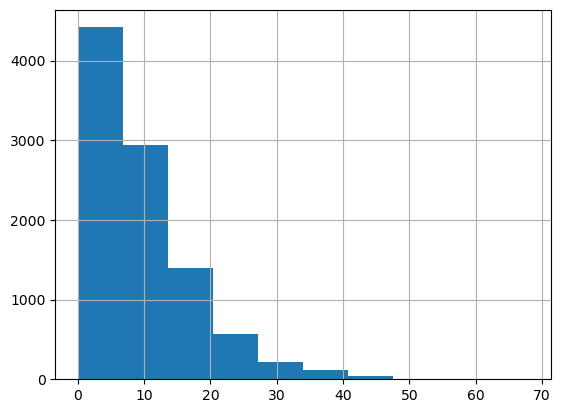

In [9]:
agg_logins.hist()
plt.show()

In [10]:
# Make additional series to simplify analysis at different intervals

hourly_counts = agg_logins.resample("H").sum()
daily_counts = agg_logins.resample("D").sum()
weekly_counts = agg_logins.resample("W").sum()

In [11]:
# Let's cut off the partial weeks at the beginning and end.
# Fortunately our last day is already a Sunday, so we only
# have to cut off the first one.

weekly_counts = weekly_counts[1:]

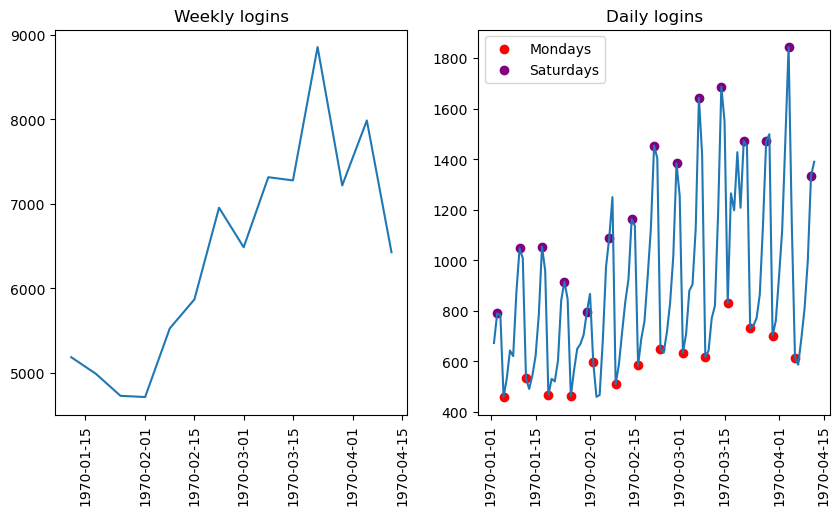

In [12]:
# By week + day

fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].plot(weekly_counts)
ax[0].set_title('Weekly logins')
ax[0].tick_params(axis='x', rotation=90)

ax[1].plot(daily_counts)
ax[1].set_title('Daily logins')
ax[1].tick_params(axis='x', rotation=90)

mondays = daily_counts[daily_counts.index.dayofweek == 0]
saturdays = daily_counts[daily_counts.index.dayofweek == 5]

ax[1].scatter(mondays.index, mondays.values, color='red', label='Mondays')
ax[1].scatter(saturdays.index, saturdays.values, color='purple', label='Saturdays')

ax[1].legend()

plt.show()

##### NOTE:
- Since we don't know the real start date, "Monday" and "Saturday" are arbitrary.

- The first "Monday" in "February" is the only one that is not a clear minimum for the week. Investigation is warranted.

- The third week in "March" shows unusual behavior (weekly activity is more frontloaded, then more sporadic). If the months/days are correct, this could be due to Spring Break. Either way, investigation is warranted.

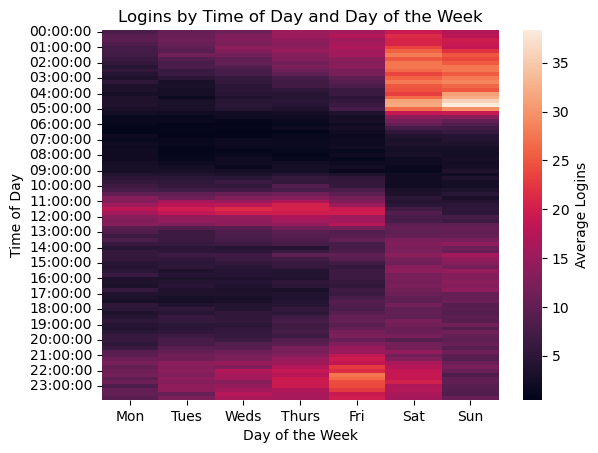

In [13]:
# Now let's look at patterns within the day. This is easier with a df.
dow_df = pd.DataFrame(agg_logins)
dow_df['day_of_week'] = dow_df.index.dayofweek

# Group by day of week and 15-minute interval
grouped = dow_df.groupby([dow_df.index.time, 'day_of_week']).mean().unstack()

# Plot a heatmap
sns.heatmap(grouped, cbar_kws={'label': 'Average Logins'})
plt.title('Logins by Time of Day and Day of the Week')
plt.xlabel('Day of the Week')
plt.xticks([x+.5 for x in range(7)], ['Mon', 'Tues', 'Weds', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('Time of Day')
plt.show()

#### NOTE:

- This visualization certainly shows a big difference in the days we've been calling Saturday and Sunday, suggesting thta this might be correct.

- The timing on weekends seems off. Why are we getting so many logins at 5am? We should confirm this with the provider of the data.

# Conclusions

1. The timestamps have one certain problem (unknown start date) and one probable problem (weekend timestamps may be inaccurate). Both of these should be confirmed with the data source.

2. Overall usage has increased over the 100-day period, but variance is still high.

3. "Mondays" are the slowest days, and usage picks up until it peaks over the weekend.

4. During the week, usage is highest overnight and during lunch hours.

5. During weekends, usage might be highest in the wee hours of the morning, but this seems improbable and should be investigated.